C:\Users\namis\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training CNN...
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5863 - loss: 1.5135 - val_accuracy: 0.7354 - val_loss: 0.5744 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8094 - loss: 0.4879 - val_accuracy: 0.7945 - val_loss: 0.4781 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8971 - loss: 0.3014 - val_accuracy: 0.7814 - val_loss: 0.5165 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9313 - loss: 0.2143 - val_accuracy: 0.7748 - val_loss: 0.5720 - learning_rate: 0.0010
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9629 - loss: 0.1398 - val_accuracy: 0.7781 - val_loss: 0.6276 - learning_rate: 5.0000e-04
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Training LSTM...
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 390ms/step - accuracy: 0.5998 - loss: 1.4141 - val_accuracy: 0.7873 - val_loss: 0.4882 - learning_rate: 0.001

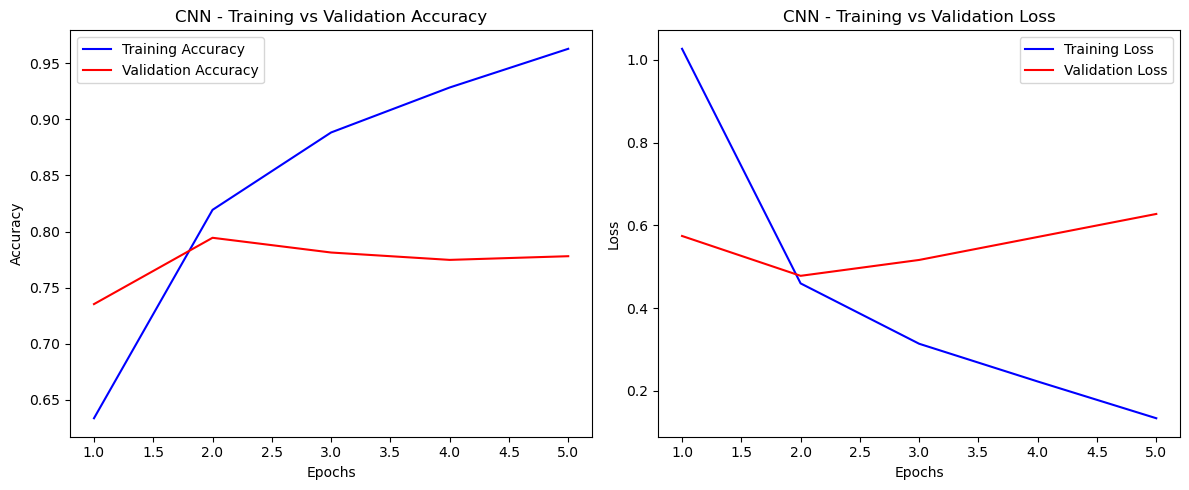

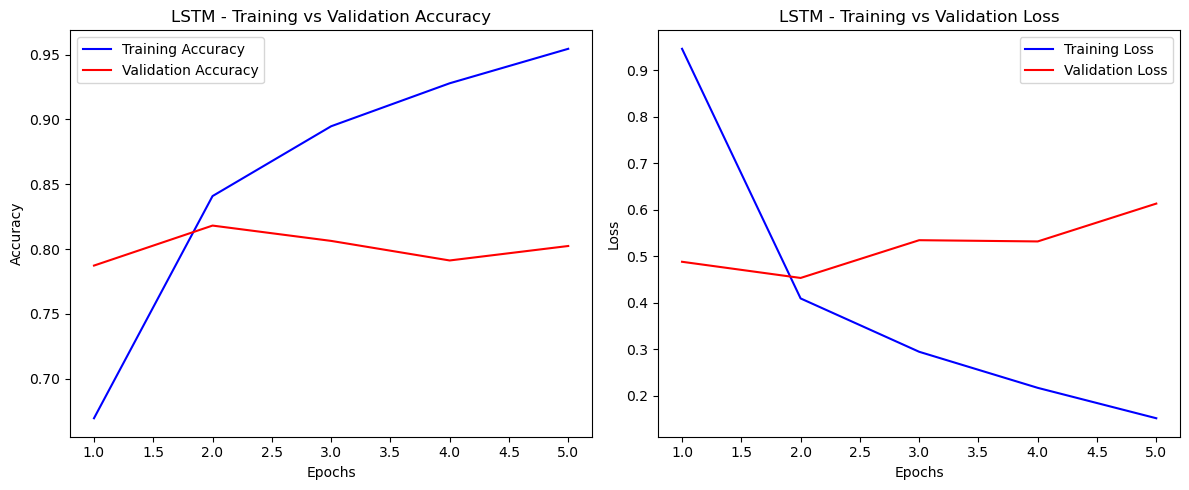

Submission file saved as submission.csv


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, GlobalMaxPooling1D, 
                                     LSTM, Dense, Dropout, Concatenate, SpatialDropout1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.linear_model import LogisticRegression

# ================================
# Load Datasets
# ================================
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

# Extract text and labels
X, y = train_df["text"].values, train_df["target"].values
X_test = test_df["text"].values

# ================================
# Preprocessing: Tokenization & Padding
# ================================
max_words = 15000  
max_length = 120   
embedding_dim = 128

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_length)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

# ================================
# CNN Model
# ================================
def build_cnn_model():
    input_layer = Input(shape=(max_length,))
    embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length)(input_layer)
    x = SpatialDropout1D(0.3)(embedding_layer)
    
    # CNN Branch
    filter_sizes = [2, 3, 5]
    conv_layers = [GlobalMaxPooling1D()(Conv1D(filters=128, kernel_size=size, activation='relu', padding="same")(x)) for size in filter_sizes]
    
    concatenated = Concatenate()(conv_layers)
    x = Dropout(0.5)(concatenated)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    return model

# ================================
# LSTM Model
# ================================
def build_lstm_model():
    input_layer = Input(shape=(max_length,))
    embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length)(input_layer)
    
    # LSTM Branch
    x = LSTM(256, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(embedding_layer)
    x = GlobalMaxPooling1D()(x)
    
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    return model

# ================================
# Callbacks for Regularization
# ================================
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

# ================================
# Train Both Models
# ================================
models = {
    "CNN": build_cnn_model(),
    "LSTM": build_lstm_model()
}

history_dict = {}
predictions = {}

for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        X_train, y_train, epochs=10, batch_size=32,
        validation_data=(X_val, y_val), verbose=1,
        callbacks=callbacks
    )
    history_dict[name] = history
    predictions[name] = model.predict(X_test_padded).flatten()

# ================================
# Simple Averaging Ensemble
# ================================
ensemble_avg_preds = (predictions["CNN"] + predictions["LSTM"]) / 2
ensemble_avg_preds = (ensemble_avg_preds > 0.5).astype(int)

# ================================
# Meta-Learner (Logistic Regression)
# ================================
train_meta_features = np.column_stack((models["CNN"].predict(X_val), models["LSTM"].predict(X_val)))
test_meta_features = np.column_stack((predictions["CNN"], predictions["LSTM"]))

meta_learner = LogisticRegression()
meta_learner.fit(train_meta_features, y_val)
meta_preds = meta_learner.predict(test_meta_features)

# ================================
# Plot Training vs Validation Accuracy & Loss
# ================================
def plot_history(history, model_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training vs Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training vs Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for CNN & LSTM
for model_name, history in history_dict.items():
    plot_history(history, model_name)

# ================================
# Final Submission
# ================================
submission = sample_submission.copy()
submission["target"] = ensemble_avg_preds  # Use Averaging Ensemble OR meta_preds for Logistic Regression
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")
